In [1]:
#导入项目所需包
import gc
import os
import shutil
import random
import cv2
import matplotlib.pyplot as plt
import math
from sklearn.model_selection  import train_test_split
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import h5py

from keras.callbacks import Callback ,EarlyStopping
from keras.models import Model, Sequential
from keras.layers import *

#导入预训练模型包
from keras.utils import to_categorical
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input as vggpi

#from keras.applications.vgg16 import decode_predictions as vggdp

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3  import preprocess_input as incv3pi

from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input as xcpi

from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input as r50pi
#from keras.applications.resnet50 import decode_predictions as r50dp


C:\Users\leo\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#数据集路径， 这里数据集目录已近修改过，train下面有两个文件夹 分别是dog和cat. 分别存放猫和狗的训练图片
#测试集test下也新建了一个test目录,在../input/test/test/下存放测试集图片。
TRAIN_DIR = '../input/train/'
TEST_DIR =  '../input/test/'

In [3]:
dogs = [
 'n02085620','n02085782','n02085936','n02086079'
,'n02086240','n02086646','n02086910','n02087046'
,'n02087394','n02088094','n02088238','n02088364'
,'n02088466','n02088632','n02089078','n02089867'
,'n02089973','n02090379','n02090622','n02090721'
,'n02091032','n02091134','n02091244','n02091467'
,'n02091635','n02091831','n02092002','n02092339'
,'n02093256','n02093428','n02093647','n02093754'
,'n02093859','n02093991','n02094114','n02094258'
,'n02094433','n02095314','n02095570','n02095889'
,'n02096051','n02096177','n02096294','n02096437'
,'n02096585','n02097047','n02097130','n02097209'
,'n02097298','n02097474','n02097658','n02098105'
,'n02098286','n02098413','n02099267','n02099429'
,'n02099601','n02099712','n02099849','n02100236'
,'n02100583','n02100735','n02100877','n02101006'
,'n02101388','n02101556','n02102040','n02102177'
,'n02102318','n02102480','n02102973','n02104029'
,'n02104365','n02105056','n02105162','n02105251'
,'n02105412','n02105505','n02105641','n02105855'
,'n02106030','n02106166','n02106382','n02106550'
,'n02106662','n02107142','n02107312','n02107574'
,'n02107683','n02107908','n02108000','n02108089'
,'n02108422','n02108551','n02108915','n02109047'
,'n02109525','n02109961','n02110063','n02110185'
,'n02110341','n02110627','n02110806','n02110958'
,'n02111129','n02111277','n02111500','n02111889'
,'n02112018','n02112137','n02112350','n02112706'
,'n02113023','n02113186','n02113624','n02113712'
,'n02113799','n02113978']

cats=['n02123045','n02123159','n02123394','n02123597'
,'n02124075','n02125311','n02127052']

In [43]:
# EDA
def savePredictToFile(filename, preds, labels):
    with h5py.File("%s.h5"%filename) as f:
        f.create_dataset("preds", data=preds)
        f.create_dataset("labels", data=labels)
    
def saveModelPredictOut(MODEL, image_size, preprocessor, Model_Name):
    print("start extract {}".format(Model_Name))
    image_tensor = Input((*image_size,3))
    image_tensor = Lambda(preprocessor)(image_tensor)

    model = MODEL(input_tensor=image_tensor, weights='imagenet', include_top=True)
    gen = image.ImageDataGenerator()
    train_generator = gen.flow_from_directory(TRAIN_DIR, image_size, shuffle=False, batch_size=32, seed = 2018)    
    preds = model.predict_generator(train_generator)
    print("finish predict{}".format(Model_Name))
    
    #保存到文件
    savePredictToFile(Model_Name, preds = preds, labels = train_generator.classes)


saveModelPredictOut(Xception, (299,299), xcpi, "xception_pred")
saveModelPredictOut(ResNet50, (299,299), r50pi, "resnet50_pred")
saveModelPredictOut(VGG16, (224,224), vggpi, "vgg_pred")

start extract vgg_pred
Found 25000 images belonging to 2 classes.
finish predictvgg_pred


In [4]:
from keras.applications.xception import decode_predictions
def getTrainNames():
    gen = image.ImageDataGenerator()
    train_generator = gen.flow_from_directory(TRAIN_DIR, (299,299), shuffle=False, batch_size=32, seed = 2018)
    names = []
    for i, fname in enumerate(train_generator.filenames):
        #index = int(fname[fname.rfind('/')+1:fname.rfind('.')])
        names.append(fname)
    return names
filenames = getTrainNames()


Found 25000 images belonging to 2 classes.


In [5]:
def read_pred(top = 50):
    allpreds = []  
    labels = None
    for model_file_name in ['xception_pred', 'resnet50_pred', 'vgg_pred']:
        with h5py.File("%s.h5"%model_file_name, 'r') as f:
            allpreds.append(decode_predictions(np.array(f['preds']), top = top))
            labels = np.array(f['labels'])
    return  allpreds, labels


In [6]:
#去除非猫非狗异常图片
def getAbnormal(Allpreds, labels, filenames):
    ndnc_abnormal = []
    select = []
    for index in range(len(labels)):
        isDogs = []
        isCats = []
        for preds in allpreds:
            isDog = False
            isCat = False
            for pred in preds[index]:
                if pred[0] in cats:
                    isCat =True
                if pred[0] in dogs:
                    isDog = True
            isDogs.append(isDog)
            isCats.append(isCat)

        #猫狗都不存在
        if labels[index] == 1 and (not (True in isDogs)):
            ndnc_abnormal.append(filenames[index])
            select.append(False)
        elif labels[index] == 0 and (not (True in isCats)):
            ndnc_abnormal.append(filenames[index])
            select.append(False)
        else:
            select.append(True)
    return ndnc_abnormal, select

def showAbnormal(ndnc_abnormal, start = 0):
    index = 331
    for file in ndnc_abnormal[start:start+9]:
        img = cv2.imread(TRAIN_DIR + file)
        plt.subplot(index)
        plt.imshow(img)
        index = index + 1
    plt.show()
        

In [71]:
allpreds,labels = read_pred(60)
ndnc_abnormal, select= getAbnormal(allpreds, labels, filenames)


In [72]:
print(len(ndnc_abnormal)/len(labels))
print(len(ndnc_abnormal))

0.00132
33


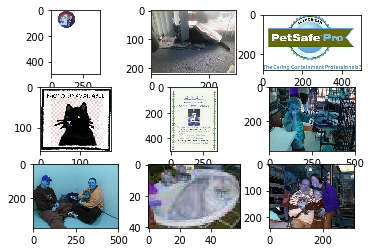

In [73]:
showAbnormal(ndnc_abnormal)

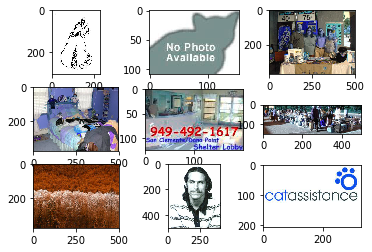

In [74]:
showAbnormal(ndnc_abnormal,9)

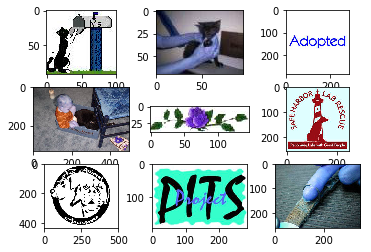

In [75]:
showAbnormal(ndnc_abnormal,18)

In [76]:
#从硬盘读取之前导出的特征到内存，并且把三个模型的特征拼接在一起
def getFeatureFromFiles(file_list):
    X_train = []
    X_test = []
    for model_file_name in file_list:
        with h5py.File(model_file_name, 'r') as f:
            X_train.append(np.array(f['X_train']))
            X_test.append(np.array(f['X_test']))
            y_train = np.array(f['y_train'])
            
    #将三个模型提取的特征拼接在一起
    X_train = np.concatenate(X_train, axis=1)
    X_test = np.concatenate(X_test, axis=1)
    return X_train, X_test, y_train

#记录每个epoch 的loss和验证集的正确率，方便后续可视化观察。
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        self.val_acc = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_acc.append(logs.get('val_acc'))

# 获取测试集的ID。 因为我们ImageDataGenerator 在导出图片特征时，我们没有打乱图片顺序（shuffle=False），
# 所以我们可以用同样的ImageDataGenerator从文件名中提取测试集数据的ID顺序。这样我们就可以和预测的值对应上。
def getTestIds():
    gen = image.ImageDataGenerator()
    test_generator = gen.flow_from_directory(TEST_DIR, (224, 224), shuffle=False, batch_size=16, class_mode=None)
    ids = []
    for i, fname in enumerate(test_generator.filenames):
        index = int(fname[fname.rfind('/')+1:fname.rfind('.')]) #for linux
        #index = int(fname[fname.rfind('\\')+1:fname.rfind('.')]) #for windows
        ids.append(index)
    return ids

#将预测结果按ID排序后写入pred.csv文件。
def savePred(ids, y_pred, filename = 'pred.csv'):
    #这里我们使用了一个小技巧，将预测值限定在0.005~0.995范围内，
    #由于kaggle评测采用的是logLoss, 而LogLoss计算中
    #如果预测正确了log(1) 与log(0.995) 只差了约0.0002. 
    #但是如果预测错误了log(0) kaggle计算中值为-15 而log(0.005) 值为-2.3 相差 12.7。
    y_pred = y_pred.clip(min=0.005, max=0.995)

    submission = pd.DataFrame()
    submission['id'] = ids
    submission['label'] = y_pred
    submission.sort_values('id', inplace = True)
    submission.to_csv(filename, index=None)


In [77]:
#设置随机种子， 以保障模型可复现
np.random.seed(2018)

#从文件加载数据集
#已保存模型包括 "vgg16.h5", "resnet50.h5", "inceptionv3.h5","xception.h5"
X_train, X_test, y_train = getFeatureFromFiles(["resnet50.h5", "inceptionv3.h5","xception.h5"])


In [78]:

X_train = X_train[select]
y_train = y_train[select]

In [79]:

#因为我们猫狗是分开的，所以我们随机打乱顺序，好让训练时每个batch 猫狗数据均匀。
X_train, y_train = shuffle(X_train, y_train)

In [104]:
#准备训练过程中的回调函数和优化器
np.random.seed(2018)
history = LossHistory()
earlystop = EarlyStopping(monitor='val_loss', patience=3, verbose=0, mode='auto')
adam = keras.optimizers.Adam(lr=0.0002)

#构建模型
model = Sequential()
model.add(Dropout(0.5, input_shape = X_train.shape[1:]))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=adam,
              loss='binary_crossentropy',
              metrics=['accuracy'])

#训练
model.fit(X_train, y_train, batch_size=128, nb_epoch=64, validation_split=0.2, callbacks = [history,earlystop])

#预测
y_pred = model.predict(X_test, verbose=1)

#保存结果
ids = getTestIds()
savePred(ids, y_pred)

C:\Users\leo\Anaconda3\envs\tensorflow\lib\site-packages\keras\models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 19973 samples, validate on 4994 samples
Epoch 1/64
19973/19973 [==============================] - 5s 226us/step - loss: 0.1958 - acc: 0.9293 - val_loss: 0.0494 - val_acc: 0.9914
Epoch 2/64
19973/19973 [==============================] - 4s 190us/step - loss: 0.0453 - acc: 0.9903 - val_loss: 0.0300 - val_acc: 0.9920
Epoch 3/64
19973/19973 [==============================] - 4s 193us/step - loss: 0.0313 - acc: 0.9926 - val_loss: 0.0235 - val_acc: 0.9948
Epoch 4/64
19973/19973 [==============================] - 4s 182us/step - loss: 0.0252 - acc: 0.9938 - val_loss: 0.0202 - val_acc: 0.9952
Epoch 5/64
19973/19973 [==============================] - 4s 190us/step - loss: 0.0214 - acc: 0.9936 - val_loss: 0.0184 - val_acc: 0.9954
Epoch 6/64
19973/19973 [==============================] - 4s 181us/step - loss: 0.0191 - acc: 0.9943 - val_loss: 0.0172 - val_acc: 0.9952
Epoch 7/64
19973/19973 [==============================] - 4s 183us/step - loss: 0.0183 - acc: 0.9945 - val_loss: 0.0162 - v

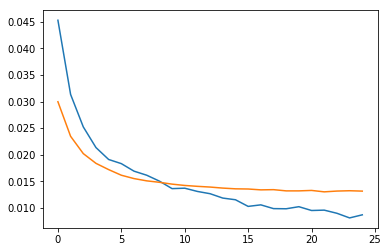

In [105]:
#训练过程 loss可视化
plt.plot(history.losses[1:])
plt.plot(history.val_losses[1:])

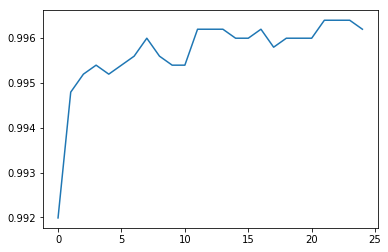

In [106]:
plt.plot(history.val_acc[1:])